In [1]:
from dataclasses import asdict
import pandas as pd
from pprint import pprint
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json

from martignac.nomad.entries import (
    get_all_my_uploads,
    get_entries_in_database,
    DEFAULT_DATABASE,
)
from martignac.nomad.uploads import delete_upload

from martignac.workflows.solute_generation import project as solute_gen_project
from martignac.workflows.solvent_generation import project as solvent_gen_project
from martignac.workflows.solute_solvation import project as solute_solvation_project
from martignac.workflows.alchemical_transformation import project as alchem_transf_project

from martignac.nomad.workflows import NomadWorkflow, NomadWorkflowArchive

def clear_jobs_for_project(project):
    for job in list(project.find_jobs({})):
        job.clear()

24-03-27 18:19:16 - MDAnalysis.coordinates.AMBER - WARNING - netCDF4 is not available. Writing AMBER ncdf files will be slow.
24-03-27 18:19:16 - pymbar.timeseries - WARNING - Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
24-03-27 18:19:17 - pymbar.mbar_solvers - WARNING - 
********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************
24-03-27 18:19:17 - pymbar.mbar_solvers - INFO - JAX was either not detected or disabled, using standard NumPy and SciPy


In [2]:
# clear_jobs_for_project(alchem_transf_project)

## Graph

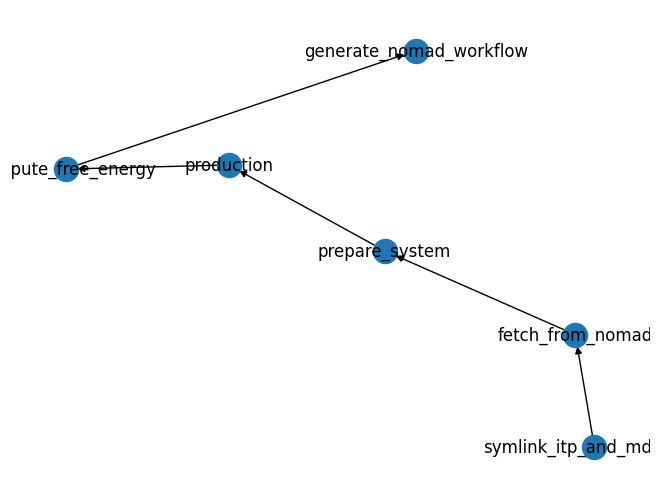

In [3]:
project = alchem_transf_project
ops = project.operations.keys()
adj = np.asarray(project.detect_operation_graph())

plt.figure()
g = nx.DiGraph(adj)
pos = nx.spring_layout(g)
nx.draw(g, pos)
nx.draw_networkx_labels(
    g, pos,
    labels={key: name for (key, name) in
            zip(range(len(ops)), [o for o in ops])})

plt.show()

## Workflow

In [2]:
job = list(alchem_transf_project.find_jobs())[0]
job

Job(project=AlchemicalTransformationFlow('/Users/bereau/work/projects/martignac/workspaces/alchemical_transformation'), statepoint={'type': 'alchemical_transformation', 'solvent_name': 'OCO', 'solute_name': 'P6', 'lambda_state': 0})

In [3]:
workflow = NomadWorkflow(alchem_transf_project, job, is_top_level=False)
workflow

NomadWorkflow(project=AlchemicalTransformationFlow('/Users/bereau/work/projects/martignac/workspaces/alchemical_transformation'), job=Job(project=AlchemicalTransformationFlow('/Users/bereau/work/projects/martignac/workspaces/alchemical_transformation'), statepoint={'type': 'alchemical_transformation', 'solvent_name': 'OCO', 'solute_name': 'P6', 'lambda_state': 0}), is_top_level=False, add_job_id=False)

In [4]:
workflow.graph.nodes, workflow.graph.edges

(NodeView(('production', 'compute_free_energy')),
 OutEdgeView([('production', 'compute_free_energy')]))

In [5]:
pprint(workflow.generate_archive().to_dict())

{'workflow2': {'inputs': [{'name': 'production',
                           'section': '../upload/archive/mainfile/alchemical_transformation_production-0.log#/run/0/calculation/0'}],
               'outputs': [{'name': 'compute_free_energy',
                            'section': '#/run/0/calculation/-1'}],
               'tasks': [{'inputs': [{'name': 'input',
                                      'section': '../upload/archive/mainfile/alchemical_transformation_production-0.log#/run/0/calculation/0'}],
                          'm_def': 'nomad.datamodel.metainfo.workflow.TaskReference',
                          'name': 'production',
                          'outputs': [{'name': 'output',
                                       'section': '../upload/archive/mainfile/alchemical_transformation_production-0.log#/run/0/calculation/-1'}],
                          'task': '../upload/archive/mainfile/alchemical_transformation_production-0.log#/workflow2'},
                         {'inputs'

## Top-level-workflow

In [6]:
top_level_workflow = NomadWorkflow(alchem_transf_project, job, is_top_level=True)
top_level_workflow

NomadWorkflow(project=AlchemicalTransformationFlow('/Users/bereau/work/projects/martignac/workspaces/alchemical_transformation'), job=Job(project=AlchemicalTransformationFlow('/Users/bereau/work/projects/martignac/workspaces/alchemical_transformation'), statepoint={'type': 'alchemical_transformation', 'solvent_name': 'OCO', 'solute_name': 'P6', 'lambda_state': 0}), is_top_level=True, add_job_id=False)

In [7]:
top_level_workflow.graph.nodes, top_level_workflow.graph.edges

(NodeView(('prepare_system', 'production', 'compute_free_energy')),
 OutEdgeView([('prepare_system', 'production'), ('production', 'compute_free_energy')]))

In [8]:
pprint(top_level_workflow.generate_archive().to_dict())

{'workflow2': {'inputs': [{'name': 'prepare_system',
                           'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/0'}],
               'outputs': [{'name': 'compute_free_energy',
                            'section': '#/run/0/calculation/-1'}],
               'tasks': [{'inputs': [{'name': 'input',
                                      'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/0'}],
                          'm_def': 'nomad.datamodel.metainfo.workflow.TaskReference',
                          'name': 'prepare_system',
                          'outputs': [{'name': 'output',
                                       'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/-1'}],
                          'task': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/m

In [9]:
archive = NomadWorkflowArchive.from_multiple_jobs(alchem_transf_project, list(alchem_transf_project.find_jobs()))

In [10]:
archive.to_dict()

{'workflow2': {'inputs': [{'name': 'prepare_system',
    'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/0'}],
  'outputs': [{'name': 'compute_free_energy',
    'section': '#/run/0/calculation/-1'}],
  'tasks': [{'name': 'prepare_system',
    'm_def': 'nomad.datamodel.metainfo.workflow.TaskReference',
    'inputs': [{'name': 'input',
      'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/0'},
     {'name': 'input',
      'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/0'},
     {'name': 'input',
      'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/run/0/calculation/0'},
     {'name': 'input',
      'section': '/uploads/4QNMReZQSiWWbPnum6yqeQ/archive/mainfile/full_workflow.solute_solvation.archive.yaml#/ru

In [12]:
archive.tasks[0].inputs

[NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=0, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ'),
 NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=0, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ'),
 NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=0, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ'),
 NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=0, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ')]

In [26]:
[t.inputs for t in archive.tasks if t.name == "production"]

[[NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=-1, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ')],
 [NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=-1, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ')],
 [NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=-1, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ')],
 [NomadSection(name='input', section_type='workflow', label='full_workflow.solute_solvation.archive.yaml', snapshot_number=-1, run_number=0, upload_id='4QNMReZQSiWWbPnum6yqeQ')]]

In [36]:
final_tasks = []
for task in archive.tasks:
    if task.name not in [t.name for t in final_tasks]:
        final_tasks.append(task)
    else:
        dest_task = next(t for t in final_tasks if t.name == task.name)
        dest_task.inputs.extend(task.inputs)
        dest_task.outputs.extend(task.outputs)
print([t.name for t in final_tasks])

['prepare_system', 'production', 'compute_free_energy']
